In [1]:
from __future__ import print_function, division
from pyspark import SparkConf, SparkContext
from pyspark.sql import SparkSession
spark = SparkSession.builder.master("local[4]") \
   .appName("test") \
   .enableHiveSupport() \
   .getOrCreate()

sc = spark.sparkContext

# Part 1: Apache Web Server Log file format

今天要使用 Apache Common Log Format(CLF)．每一条Log 长得像这样

`127.0.0.1 - - [01/Aug/1995:00:00:01 -0400] "GET /images/launch-logo.gif HTTP/1.0" 200 1839`

每个部分的说明如下:

`127.0.0.1` Client 的 ip 位置．

`[01/Aug/1995:00:00:01 -0400]` 请求发生的时间. 格式为: [day/month/year:hour:minute:second timezone]

  - #### day = 2 digits
  - #### month = 3 letters
  - #### year = 4 digits
  - #### hour = 2 digits
  - #### minute = 2 digits
  - #### second = 2 digits
  - #### zone = (+ | -) 4 digits
  
`"GET /images/launch-logo.gif HTTP/1.0"` 请求的第一行

`200` 此次请求的状态码

`1839` 传回 Clinet 端的物件大小

## NASA-HTTP Web Server Log

资料将使用 NASA Kennedy Space Center 的网站 Server 资料．这是一个公开资料可以在http://ita.ee.lbl.gov/html/contrib/NASA-HTTP.html 找到．

或是你也可以直接从这里下载 ftp://ita.ee.lbl.gov/traces/NASA_access_log_Jul95.gz

#### 下載資料需要解壓縮並放到 HDFS

```bash
gunzip NASA_access_log_Jul95.gz
hadoop fs -put NASA_access_log_Jul95 /tmp
```

### 1.1 Parsing Each Log Line


In [5]:
import re
import datetime

from pyspark.sql import Row

month_map = {'Jan': 1, 'Feb': 2, 'Mar':3, 'Apr':4, 'May':5, 'Jun':6, 'Jul':7,
    'Aug':8,  'Sep': 9, 'Oct':10, 'Nov': 11, 'Dec': 12}

def parse_apache_time(s):
    """ Convert Apache time format into a Python datetime object
    Args:
        s (str): date and time in Apache time format
    Returns:
        datetime: datetime object (ignore timezone for now)
    """
    return datetime.datetime(int(s[7:11]),
                             month_map[s[3:6]],
                             int(s[0:2]),
                             int(s[12:14]),
                             int(s[15:17]),
                             int(s[18:20]))


def parseApacheLogLine(logline):
    """ Parse a line in the Apache Common Log format
    Args:
        logline (str): a line of text in the Apache Common Log format
    Returns:
        tuple: either a dictionary containing the parts of the Apache Access Log and 1,
               or the original invalid log line and 0
    """
    match = re.search(APACHE_ACCESS_LOG_PATTERN, logline)
    if match is None:
        return (logline, 0)
    size_field = match.group(9)
    if size_field == '-':
        size = long(0)
    else:
        size = long(match.group(9))
    return (Row(
        host          = match.group(1),
        client_identd = match.group(2),
        user_id       = match.group(3),
        date_time     = parse_apache_time(match.group(4)),
        method        = match.group(5),
        endpoint      = match.group(6),
        protocol      = match.group(7),
        response_code = int(match.group(8)),
        content_size  = size
    ), 1)

In [3]:
# A regular expression pattern to extract fields from the log line
APACHE_ACCESS_LOG_PATTERN = '^(\S+) (\S+) (\S+) \[([\w:/]+\s[+\-]\d{4})\] "(\S+) (\S+)\s*(\S*)" (\d{3}) (\S+)'

### 1.2 建立RDD


In [7]:
def parseLogs(logFile):
    """ Read and parse log file """
    parsed_logs = (sc
                   .textFile(logFile)
                   .map(parseApacheLogLine)
                   .cache())

    access_logs = (parsed_logs
                   .filter(lambda s: s[1] == 1)
                   .map(lambda s: s[0])
                   .cache())

    failed_logs = (parsed_logs
                   .filter(lambda s: s[1] == 0)
                   .map(lambda s: s[0]))
    failed_logs_count = failed_logs.count()
    
    if failed_logs_count > 0:
        print('Number of invalid logline: {}'.format(failed_logs.count()))
        for line in failed_logs.take(20):
            try:
                print('Invalid logline: {}'.format(str(line)))
            except Exception:
                pass

    print('Read {} lines, successfully parsed {} lines, failed to parse {} lines'.format(parsed_logs.count(), access_logs.count(), failed_logs.count()))
    return parsed_logs, access_logs, failed_logs




In [ ]:
parsed_logs, access_logs, failed_logs = parseLogs('hdfs:///tmp/NASA_access_log_Jul95')

### 1.3 資料清洗


In [31]:
## 测试不同的 Log Pattern
APACHE_ACCESS_LOG_PATTERN = '^(\S+) (\S+) (\S+) \[([\w:/]+\s[+\-]\d{4})\] "(\S+) (\S+)\s*(\S*)\s*" (\d{3}) (\S+)'

In [8]:
parsed_logs, access_logs, failed_logs = parseLogs('hdfs:///tmp/NASA_access_log_Jul95')

Number of invalid logline: 849
Invalid logline: 204.120.229.63 - - [01/Jul/1995:04:29:05 -0400] "GET /history/history.html                                                 hqpao/hqpao_home.html HTTP/1.0" 200 1502
Invalid logline: nccse.gsfc.nasa.gov - - [01/Jul/1995:07:36:13 -0400] "GET /shuttle/missions/missions.html Shuttle Launches from Kennedy Space Center HTTP/1.0" 200 8677
Invalid logline: ix-nbw-nj1-22.ix.netcom.com - - [01/Jul/1995:10:42:09 -0400] "GET /finger @net.com HTTP/1.0" 404 -
Invalid logline: gpotterpc.llnl.gov - - [01/Jul/1995:22:26:51 -0400] "GET /htbin/wais.pl?orbit sts71 HTTP/1.0" 200 317
Invalid logline: wxs6-7.worldaccess.nl - - [02/Jul/1995:08:09:27 -0400] "GET / /   HTTP/1.0" 200 7074
Invalid logline: wxs6-7.worldaccess.nl - - [02/Jul/1995:08:11:20 -0400] "GET / /facts/facts.html HTTP/1.0" 200 7074
Invalid logline: s29.abqslip.indirect.com - - [02/Jul/1995:14:24:26 -0400] "GET /htbin/wais.pl?Wake Shield HTTP/1.0" 200 7020
Invalid logline: wxs6-4.worldaccess.nl -

## Part 2:  Log 资料基本分析

### 2.1 内容大小统计


In [9]:
# Calculate statistics based on the content size.
content_sizes = access_logs.map(lambda log: log.content_size).cache()
print('Content Size Avg: %i, Min: %i, Max: %s' % (
    content_sizes.reduce(lambda a, b : a + b) / content_sizes.count(),
    content_sizes.min(),
    content_sizes.max()))


Content Size Avg: 20464, Min: 0, Max: 6823936


### 2.2 Response Code 分析

In [10]:
# Response Code to Count
responseCodeToCount = (access_logs
                       .map(lambda log: (log.response_code, 1))
                       .reduceByKey(lambda a, b : a + b)
                       .cache())
responseCodeToCountList = responseCodeToCount.take(100)
print('Found %d response codes' % len(responseCodeToCountList))
print('Response Code Counts: %s' % responseCodeToCountList)


Found 7 response codes
Response Code Counts: [(200, 1700757), (304, 132626), (404, 10784), (500, 62), (302, 46569), (403, 54), (501, 14)]


### 2.2 使用 Matplotlib 画图  

In [11]:
labels = responseCodeToCount.map(lambda (x, y): x).collect()
print(labels)
count = access_logs.count()
fracs = responseCodeToCount.map(lambda (x, y): (float(y) / count)).collect()
print(fracs)

[200, 304, 404, 500, 302, 403, 501]
[0.8994592953704811, 0.07014034839063159, 0.00570320689038779, 3.278920875408411e-05, 0.02462839778175714, 2.8558343108395834e-05, 7.404014879954476e-06]


In [14]:
%matplotlib inline

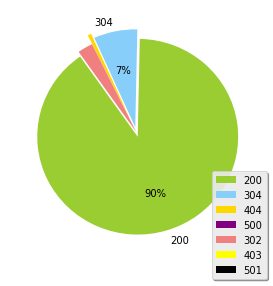

In [16]:
import matplotlib.pyplot as plt
def pie_pct_format(value):
    """ Determine the appropriate format string for the pie chart percentage label
    Args:
        value: value of the pie slice
    Returns:
        str: formated string label; if the slice is too small to fit, returns an empty string for label
    """
    return '' if value < 7 else '%.0f%%' % value

fig = plt.figure(figsize=(4.5, 4.5), facecolor='white', edgecolor='white')
colors = ['yellowgreen', 'lightskyblue', 'gold', 'purple', 'lightcoral', 'yellow', 'black']
explode = (0.05, 0.05, 0.1, 0, 0, 0, 0)
patches, texts, autotexts = plt.pie(fracs, labels=labels, colors=colors,
                                    explode=explode, autopct=pie_pct_format,
                                    shadow=False,  startangle=125)
for text, autotext in zip(texts, autotexts):
    if autotext.get_text() == '':
        text.set_text('')  # If the slice is small to fit, don't show a text label
plt.legend(labels, loc=(0.80, -0.1), shadow=True)
pass

### 2.4 Frequent Hosts

In [19]:
hostCountPairTuple = access_logs.map(lambda log: (log.host, 1))

hostSum = hostCountPairTuple.reduceByKey(lambda a, b : a + b)

hostMoreThan10 = hostSum.filter(lambda s: s[1] > 10)

hostsPick20 = (hostMoreThan10
               .map(lambda s: s[0])
               .take(20))

print('Any 20 hosts that have accessed more then 10 times: %s' % hostsPick20)

Any 20 hosts that have accessed more then 10 times: [u'sl137.active.ch', u'ppp8.ifa.hawaii.edu', u'sjackson.seanet.com', u'p10.superlink.net', u'134.134.192.7', u'liblrd-class9.tamu.edu', u'dd08-048.compuserve.com', u'198.53.162.184', u'199.77.67.7', u'204.92.50.3', u'gs1.cs.ttu.edu', u'wilma.netinfo.com.au', u'dcn60.dcn.davis.ca.us', u'haskell.limbex.com', u'celebrian.otago.ac.nz', u'slip1-25.acs.ohio-state.edu', u'daha-78-138.ipt.aol.com', u'159.142.136.214', u'203.17.12.1', u'acapulco.nynexst.com']


### 2.5 將 Endpoints 視覺化

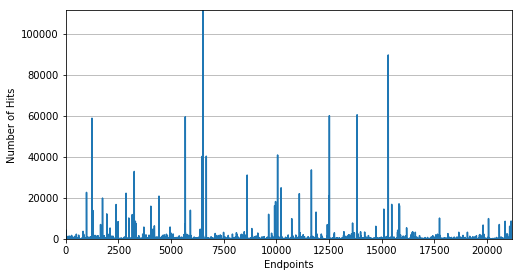

In [20]:
endpoints = (access_logs
             .map(lambda log: (log.endpoint, 1))
             .reduceByKey(lambda a, b : a + b)
             .cache())
ends = endpoints.map(lambda (x, y): x).collect()
counts = endpoints.map(lambda (x, y): y).collect()

fig = plt.figure(figsize=(8,4.2), facecolor='white', edgecolor='white')
plt.axis([0, len(ends), 0, max(counts)])
plt.grid(b=True, which='major', axis='y')
plt.xlabel('Endpoints')
plt.ylabel('Number of Hits')
plt.plot(counts)
pass

## Part 3: 分析網站伺服器 Log 

### 3.1 Top Ten Error Endpoints

In [32]:
not200 = access_logs.filter(lambda log: log.response_code != 200)

endpointCountPairTuple = not200.map(lambda log: (log.endpoint, 1))

endpointSum = endpointCountPairTuple.reduceByKey(lambda a, b : a + b)

topTenErrURLs = endpointSum.takeOrdered(10, lambda s: -1 * s[1])
print('Top Ten failed URLs: %s' % topTenErrURLs)


Top Ten failed URLs: [(u'/images/NASA-logosmall.gif', 21010), (u'/images/KSC-logosmall.gif', 12435), (u'/images/MOSAIC-logosmall.gif', 6628), (u'/images/USA-logosmall.gif', 6577), (u'/images/WORLD-logosmall.gif', 6413), (u'/images/ksclogo-medium.gif', 5837), (u'/images/launch-logo.gif', 4628), (u'/shuttle/countdown/liftoff.html', 3509), (u'/shuttle/countdown/', 3345), (u'/shuttle/countdown/images/cdtclock.gif', 3251)]



### 3.2 Number of Unique Hosts

In [24]:
hosts = access_logs.map(lambda log: log.host)

uniqueHosts = hosts.distinct()

uniqueHostCount = uniqueHosts.count()
print('Unique hosts: %d' % uniqueHostCount)


Unique hosts: 81971


### 3.3 Number of Unique Daily Hosts

In [36]:
dayToHostPairTuple = access_logs.map(lambda log: (log.date_time.day, log.host)).distinct()

dayGroupedHosts = dayToHostPairTuple.groupByKey()

dayHostCount = dayGroupedHosts.map(lambda (day, hosts): (day, len(hosts)))

dailyHosts = (dayHostCount
              .sortByKey()
              .cache())
dailyHostsList = dailyHosts.take(30)
print('Unique hosts per day: %s' % dailyHostsList)

Unique hosts per day: [(1, 5192), (2, 4859), (3, 7335), (4, 5522), (5, 7382), (6, 7819), (7, 6473), (8, 2897), (9, 2553), (10, 4464), (11, 4924), (12, 5345), (13, 6951), (14, 5296), (15, 3116), (16, 3012), (17, 4943), (18, 4522), (19, 4918), (20, 4727), (21, 4339), (22, 2575), (23, 2635), (24, 4297), (25, 4376), (26, 4296), (27, 4368), (28, 2175)]


### 3.4 Visualizing the Number of Unique Daily Hosts

In [26]:
daysWithHosts = dailyHosts.map(lambda log: log[0]).collect()
hosts = dailyHosts.map(lambda log: log[1]).collect()

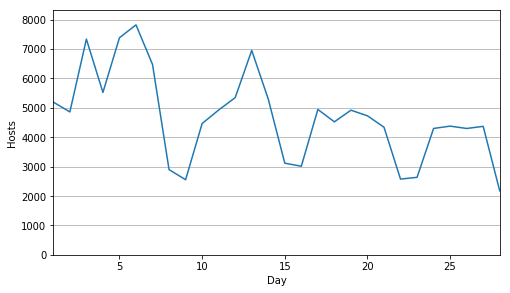

In [27]:
fig = plt.figure(figsize=(8,4.5), facecolor='white', edgecolor='white')
plt.axis([min(daysWithHosts), max(daysWithHosts), 0, max(hosts)+500])
plt.grid(b=True, which='major', axis='y')
plt.xlabel('Day')
plt.ylabel('Hosts')
plt.plot(daysWithHosts, hosts)

### 3.5 Average Number of Daily Requests per Hosts

In [37]:
dayAndHostTuple = access_logs.map(lambda log: (log.date_time.day, log.host))

groupedByDay = dayAndHostTuple.groupByKey()

sortedByDay = groupedByDay.sortByKey()

avgDailyReqPerHost = (sortedByDay
                      .map(lambda(day, requests): (day, len(requests)))
                      .join(dailyHosts)
                     .map(lambda(day, (totalRequests, numOfHosts)): (day, totalRequests/numOfHosts))
                     .sortByKey()
                     .cache())
avgDailyReqPerHostList = avgDailyReqPerHost.take(30)
print('Average number of daily requests per Hosts is %s' % avgDailyReqPerHostList)

Average number of daily requests per Hosts is [(1, 12.463405238828967), (2, 12.401728750771763), (3, 12.207498295841853), (4, 12.756972111553784), (5, 12.811162286643187), (6, 12.91162552756107), (7, 13.472578402595396), (8, 13.41422160856058), (9, 13.81159420289855), (10, 16.31989247311828), (11, 16.310926076360683), (12, 17.255378858746493), (13, 19.270896273917423), (14, 15.880098187311178), (15, 14.610397946084724), (16, 15.885126162018592), (17, 15.168318834715759), (18, 14.211632021229544), (19, 14.789955266368443), (20, 14.08694732388407), (21, 14.894445724821388), (22, 13.691650485436893), (23, 14.874762808349146), (24, 14.952525017454038), (25, 14.327696526508227), (26, 13.697160148975792), (27, 14.119505494505495), (28, 12.468045977011494)]


### 3.6 Visualizing the Average Daily Requests per Unique Host

In [29]:
daysWithAvg = avgDailyReqPerHost.map(lambda (day, avg): day).collect()
avgs = avgDailyReqPerHost.map(lambda (day, avg): avg).collect()

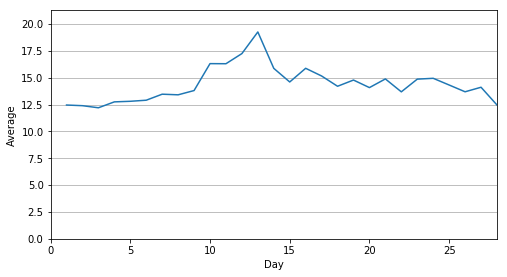

In [30]:
fig = plt.figure(figsize=(8,4.2), facecolor='white', edgecolor='white')
plt.axis([0, max(daysWithAvg), 0, max(avgs)+2])
plt.grid(b=True, which='major', axis='y')
plt.xlabel('Day')
plt.ylabel('Average')
plt.plot(daysWithAvg, avgs)
pass